In [1]:
using FluPredictibility
using FluPredictibility.BioTools, FluPredictibility.TreeTools, FluPredictibility.EarthMoversDistance
using BioSequences
using Plots
using Dates
using FastaIO
using StatsBase
using Measures, LaTeXStrings
include("../prediction_functions.jl")
include("../plot_functions.jl")
pyplot()
Flu = FluPredictibility

FluPredictibility

In [2]:
base = 20
lfs = base # Legend font size
alfs = base # axis label font size
tfs = base # title font size
atfs = base # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1200,800) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
annfs = 36


36

In [3]:
fp = Flu.AAFluPop("../alignments/aligned_ha_aa_subtree.fasta", [:strain,:?,:?,:date], 
    flulineage="h3n2");

Reading ../alignments/aligned_ha_aa_subtree.fasta...
Read 4401 strains out of 4402. Filtered 1. Could not read 0


## Important Note
I constructed this tree using 100 sequences per month from 2002.  
This is different from the rest of the analysis where I used sequences from 2000. 
--> The datebinning has to start from 2002-12-01 at earliest, otherwise the code will fail since some timebins won't have sequences

In [4]:
Flu.bin_by_date!(fp, start=Date(2002,12,1), binwidth=Day(121), binspacing=Day(121));
datebins = sort(collect(keys(fp.datebin)));

In [5]:
t = read_tree("../data/tree_raw.nwk", NodeDataType=LBIData);

  0.678043 seconds (1.88 M allocations: 169.534 MiB, 11.94% gc time)


# Using a single sequence to predict the future
We'll use different single sequence predictors: 
- a random sequence from current population
- the max. lbi from current pop. 
- the consensus
- as a comparison, the best possible? 

Efficiency of those predictors will be measured using the mean hamming distance to the future. 

In [6]:
# LBI will be computed for each datebin, using only strains alive in this bin
tau = 100 / 365 * Flu.substitution_rate["h3n2", "ha"]
Flu.get_lbi!(fp, t, :datebin, τ = tau);

In [7]:
pred_rand = Dict(); pred_lbi = Dict(); pred_cons = Dict(); pred_best = Dict();
idx = 1:length(datebins)-8
@time for i in idx
    print("i = $i/$(length(idx))             \r"); flush(stdout)
    db = datebins[i]
    pop = fp.datebin[db]
    prof = Profile(pop)
    cons = consensus(prof)
    maxlbi = reduce(pop) do x,y
        ismissing(x[:lbi]) && return y
        ismissing(y[:lbi]) && return x
        x[:lbi] > y[:lbi] ? x : y
    end
    #
    ismissing(maxlbi[:lbi]) && @warn "No lbi value - $db"
    for db2 in datebins[i:i+8]
        dt = db2[1] - db[1]
        fpop = fp.datebin[db2]
        fprof = Profile(fpop)
        pred_rand[dt] = get(pred_rand, dt, 0.) + hamming(prof, fprof) /length(idx)
        pred_lbi[dt] = get(pred_lbi, dt, 0.) + hamming(maxlbi, fprof) /length(idx)
        pred_cons[dt] = get(pred_cons, dt, 0.) + hamming(cons, fprof) /length(idx)
    end
end
pred_rand = sort(pred_rand); pred_lbi = sort(pred_lbi); pred_cons = sort(pred_cons);

  6.092102 seconds (147.02 M allocations: 2.408 GiB, 7.05% gc time)


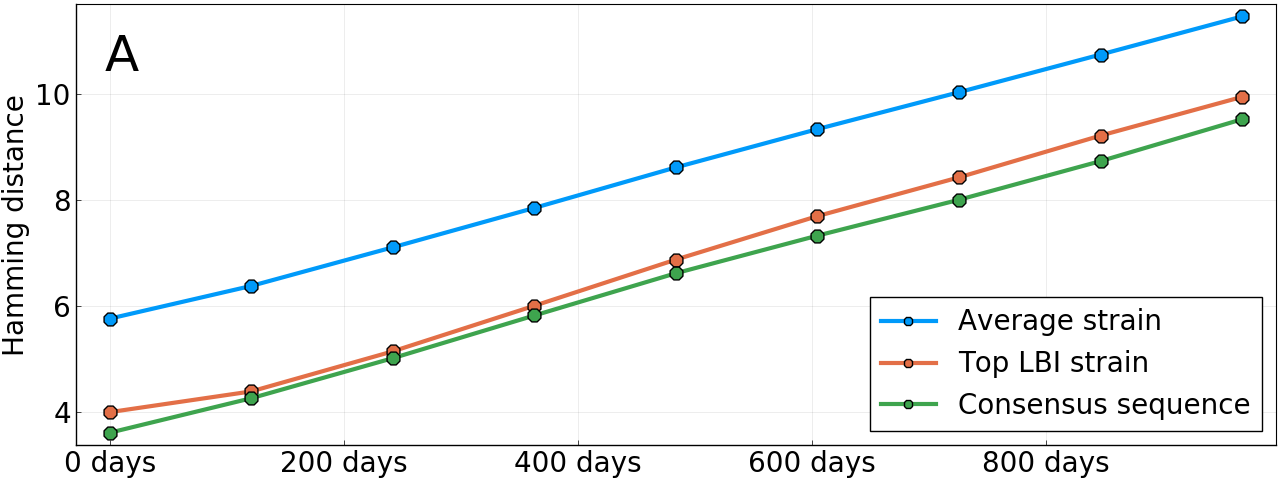

In [8]:
ts = [x[1] for x in pred_rand]
prand = [x[2] for x in pred_rand]
pcons = [x[2] for x in pred_cons]
plbi = [x[2] for x in pred_lbi]
#
p = plot(ts, prand, label="Average strain", marker=:o, markersize=10, linewidth=3)
plot!(ts, plbi, label="Top LBI strain", marker=:o, markersize=10, linewidth=3)
plot!(ts, pcons, label="Consensus sequence", marker=:o, markersize=10, linewidth=3)
#
plot!(ylabel="Hamming distance", title="Hamming distance to future population");
plot!(p, legendfontsize = lfs, axisfontsize = atfs, tickfontsize=atfs, guidefontsize=alfs, titlefontsize = alfs)
plot!(p, size = (1280,960), frame=:boxed)
p5_sb1 = plot(p, size=(1280,480), title="", legend=:bottomright, ann=(10,10.7,text("A",annfs)))

# How close is the top lbi strain to the consensus? 

In [9]:
function datebin_to_numdate(db)
    d = db[1] + div(db[2] - db[1], 2)
    return year(d) + (month(d)-1)/12 + day(d) /365
end
function numdate_to_date(d)
    y = round(Int64, d, RoundDown)
    m = round(Int64, (d - y)*12, RoundDown)
    d = round()
end

numdate_to_date (generic function with 1 method)

In [10]:
dat = Dict(); dates = Dict()
for db in datebins
    pop = fp.datebin[db]
    prof = Profile(pop)
    toplbi = reduce((x,y) -> x[:lbi] > y[:lbi] ? x : y, pop)
    cons = consensus(prof)
    dat[datebin_to_numdate(db)] = (poptocons=hamming(prof,cons), lbitocons=hamming(toplbi.seq, cons))
    dates[datebin_to_numdate(db)] = Flu.datebin_to_date(db) # For plot ticks
end
dat = sort(dat); dates = sort(dates);

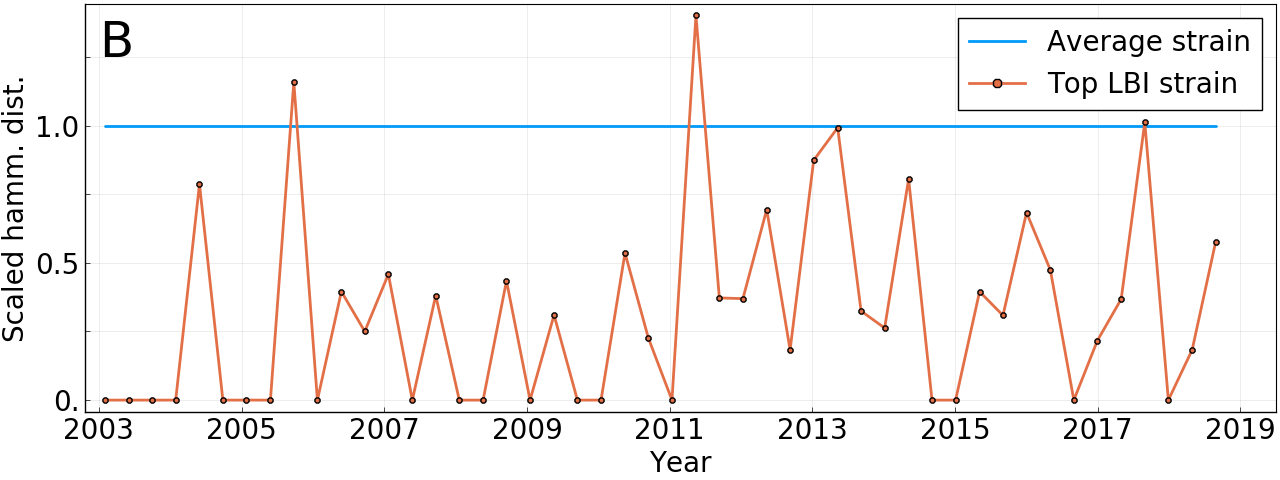

In [11]:
p = plot([x[1] for x in keys(dat)], ones(length(values(dat))), label="Average strain", line=(2))
plot!([x[1] for x in keys(dat)], [x.lbitocons for x in values(dat)]./[x.poptocons for x in values(dat)], 
    label="Top LBI strain", line=(2), marker=:o)
#
plot!(xlabel="", ylabel="Scaled hamm. dist.", title="Hamming distance to consensus sequence")
plot!(p, legendfontsize = lfs, axisfontsize = atfs, tickfontsize=atfs, guidefontsize=alfs, titlefontsize = alfs)
plot!(p, size = (1280,960), frame=:boxed)
xt = 2003:2:2020 # xticks
yt = ([0., 0.25, 0.5, 0.75, 1., 1.25],["0.", "", "0.5", "", "1.0", ""])
plot!(p, xticks = collect(xt), yticks = yt, xlabel="Year", xlim=(2002.8,2019.5))
p5_sb2 = plot(p, size=(1280,480), title="", legend=:topright, ann=(2003.25, 1.3, text("B",annfs)))


# Panel

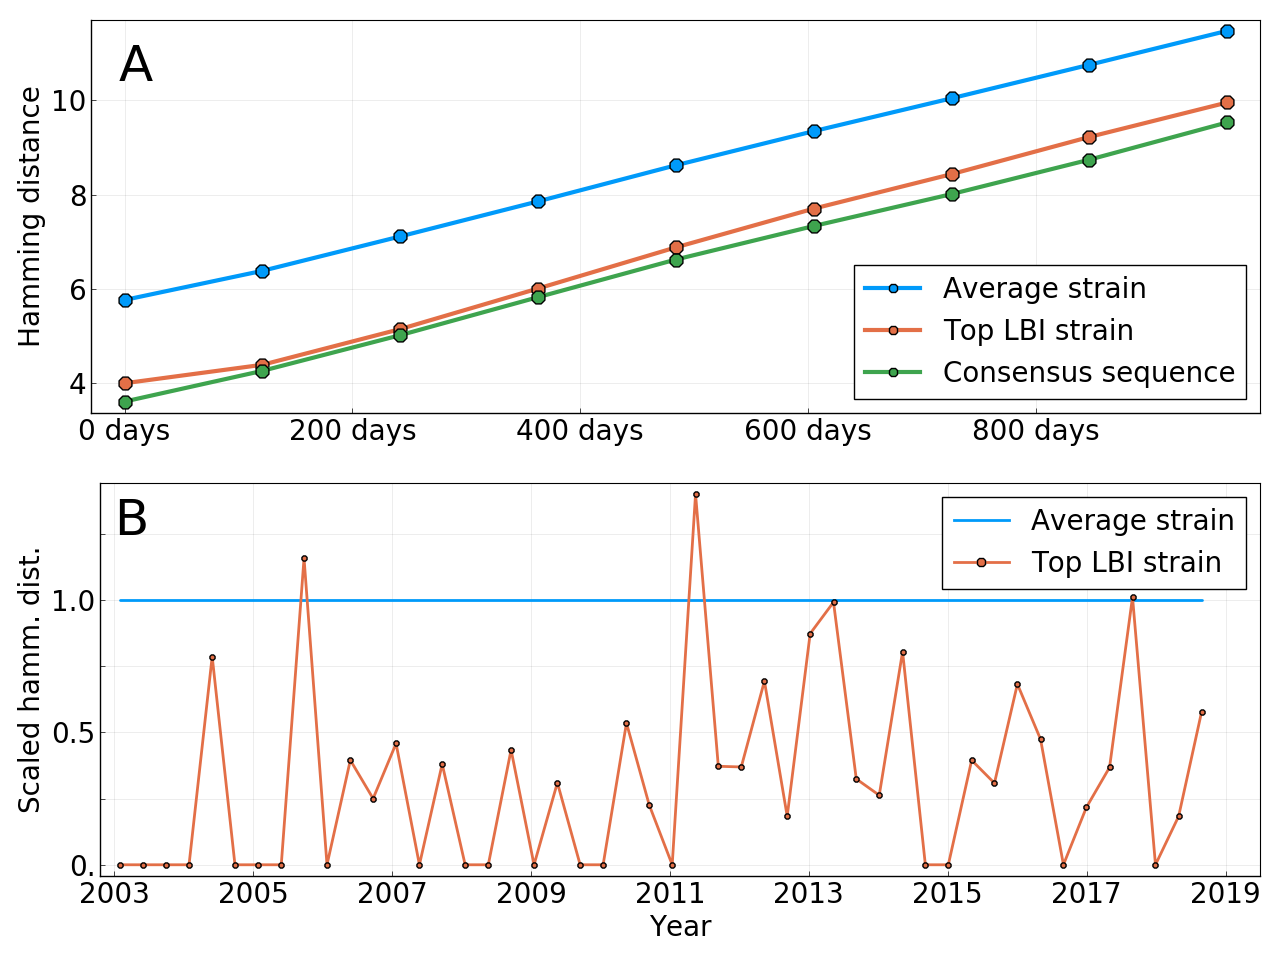

In [12]:
p5 = plot(p5_sb1, p5_sb2, layout=(grid(2,1)), size=(1280, 960), margin=5mm) 

# Using several weighted sequences to predict the future

## Cluster sequences around LBI maximas
- For each datebin, find all local maximas of the LBI. Those will be centers of clusters. 
- For each strain in the datebin, find the local maxima it is closest to in terms of *branch length distance* .
- This gives us clusters and weights (number of strains per cluster). It can be used as a proxy for the future population


In [13]:
tmp = cluster_lbi_maxima!(t, fp)
clusters = tmp[1];
clusters_lbi = tmp[2];

In [14]:
# Get consensus and weight for each cluster
# In get_predictor_bysize, weight is determined by the number of sequences in the cluster
# In get_predictor_bylbi, weight is determined by the lbi value of the corresponding local maxima
function get_predictor_bysize(clusters::Dict, fp)
    Z = Float64(sum(length(x[2]) for x in clusters))
    out = Dict{BioSequence, Float64}()
    for c in values(clusters)
        cons = BioTools.consensus([fp.strains[x].seq for x in c])
        out[cons] = get(out, cons, 0.) + length(c) / Z
    end
    return out
end
function get_predictor_bylbi(clusters::Dict, lbivals::Dict, fp)
    Z = sum(lbivals[n] for n in keys(clusters)) # Empty clusters are removed, so lbivals can have more keys
    out = Dict{BioSequence, Float64}()
    for (n,c) in clusters
        cons = BioTools.consensus([fp.strains[x].seq for x in c])
        out[cons] = get(out, cons, 0.) + lbivals[n] / Z
    end
    return out
end

get_predictor_bylbi (generic function with 1 method)

In [ ]:
## Warning : quite long to run! 
if true # false
pred_cons = Dict(); pred_clusters = Dict(); pred_all= Dict()
idx = 1:length(datebins)-8
for i in idx
    db = datebins[i]
    println(db, "")
    predictor_cons = Dict(BioTools.consensus(fp.datebin[db]).seq => 1.) # Overall consensus with weight 1
    predictor_clusters = get_predictor_bysize(clusters[db], fp) # Clusterwise consensuses
    predictor_all = EarthMoversDistance.sequence_distribution(fp.datebin[db]) # All pop. 
    for db2 in datebins[i:i+8]
        future_distribution = EarthMoversDistance.sequence_distribution(fp.datebin[db2])
        # Distance for all three predictors
        pred_cons[db2[1]-db[1]] = get(pred_cons, db2[1] - db[1], 0.) + EMD(predictor_cons, future_distribution).emd / length(idx)
        pred_clusters[db2[1]-db[1]] = get(pred_clusters, db2[1] - db[1], 0.) + EMD(predictor_clusters, future_distribution).emd / length(idx)
        pred_all[db2[1]-db[1]] = get(pred_all, db2[1] - db[1], 0.) + EMD(predictor_all, future_distribution).emd / length(idx)
    end
end
pred_cons = sort(pred_cons); pred_clusters = sort(pred_clusters); pred_all = sort(pred_all);
end

(2002-12-01, 2003-04-01)


In [ ]:
p = plot([x[1].value for x in pred_cons][1:6], [x[2] for x in pred_cons][1:6], linewidth=2, marker=(:o, 8),  label="Global consensus")
plot!([x[1].value for x in pred_clusters][1:6], [x[2] for x in pred_clusters][1:6], linewidth=2, marker=(:o, 8), label="Cluster-wise consensus")
plot!([x[1].value for x in pred_all][1:6], [x[2] for x in pred_all][1:6], linewidth=2, marker=(:o, 8), label="All present population")
# 
plot!(p, xlabel="Days to the future", ylabel="EMD", title = "EarthMover's Distance to future population")
plot!(p, legendfontsize = alfs, guidefontsize=alfs, tickfontsize=alfs, titlefontsize = alfs)
plot!(p, frame=:boxed, size=(1280,960))